# Lab 1: Problem 1 (MDP algorithms: tabular Q-learning)

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    
FrozenLake-v1 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.

More documentation: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/


In [1]:
#wandb set up for logging runs online and moving them to the leaderboard
#create a wandb account when prompted, or simply sign in if you already have an account
!pip install wandb -qqq
import wandb
wandb.login()
run=wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [2]:
## DO NOT CHANGE THIS CELL
import numpy as np
import gym
import scipy
env=gym.make('FrozenLake-v1')
#env.seed(0)

ModuleNotFoundError: No module named 'gym'

For proper accounting rewards while you learn, we build a wrapper around env.step() and env.reset(). In an episode, every time you take an action the reward will be appended to the reward of the episode, and when ever the environment is reset (at the end of an epsiode), the episode reward is reset to 0.

In [ ]:
## DO NOT CHANGE THIS CELL
#wrapper for accounting rewards
rEpisode=0
rList=[]
fixedWindow=100
movingAverage=0

def reset_decorate(func):
    def func_wrapper():
        global rList
        global movingAverage
        global rEpisode
        global fixedwindow
        rList.append(rEpisode)
        if len(rList) >= fixedWindow:
            movingAverage=np.mean(rList[len(rList)-fixedWindow:len(rList)-1])
        rEpisode=0
        return(func())
    return func_wrapper

env.reset = reset_decorate(env.reset)

def step_decorate(func):
    def func_wrapper(action):
        global rEpisode
        s1, r, d, other = func(action)
        rEpisode+=r
        return(s1, r, d, other)
    return func_wrapper

env.step = step_decorate(env.step)

def init():
    rEpisode=0
    rList=[]
    movingAverage=0
    return

Below we illustrate the execution of the Open AI gym enviornment using the policy of chosing random action in every state. Every time an action is taken the enviorment returns a tuple containing next state, reward, and the status (whether terminal state is reached or not).

In [ ]:
### RANDOM SAMPLING EXAMPLE
num_episodes=1000; #number of episodes you want to try
episode_max_length=100; #you can explicitly end the epsiode before terminal state is reached

env.reset()
#env.render()
#execute in episodes
for i in range(num_episodes):

    #reset the environment at the beginning of an episode
    s = env.reset()
    d = False #not done

    for t in range(episode_max_length):

        ################ Random action policy ###########################
        #play random action
        a = env.action_space.sample()
        #get new state, reward, done
        s, r, d, _ = env.step(a)
        #################################################################


        #break if done, reached terminal state
        if d == True:
            break


    #log per-episode reward and moving average over 100 episodes
    wandb.log({ "random reward" : rEpisode, "random reward moving average" : movingAverage, "random episode" : i})

In [11]:
def kldiv(p, q):
    print(p,q)
    if p == 0:
        return (1-p)*np.log((1-p)/(1-q))
    elif p == 1:
        return p*np.log(p/q)
    else:
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

def klucb(s, n, t, c):
    p = s/n
    q = .5
    for i in range(10):
        print(q)
        f = kldiv(p,q) - np.log(t) - c*np.log(np.log(t))
        f_prime = (q-p)/(q*(1-q))
        new_q = min(max(q-f/f_prime,0),1)
        if np.abs(new_q-q)<.001:
            print(i)
            return new_q
        else:
            q = new_q

In [19]:
!pip install SMPyBandits
from SMPyBandits.Policies.klUCBPlus import klUCBPlus

In [21]:
policy = klUCBPlus(4)

In [27]:
policy.choice()

1

In [8]:
from SMPyBandits.Policies.klUCBPlus import klUCBPlus
from SMPyBandits.Policies.CPUCB import CPUCB
from SMPyBandits.Policies.klUCB import klUCB

If you want the speed up brought by numba.jit, try to manually install numba and check that it works (installing llvmlite can be tricky, cf. https://github.com/numba/numba#custom-python-environments
Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...
If you want the speed up brought by numba.jit, try to manually install numba and check that it works (installing llvmlite can be tricky, cf. https://github.com/numba/numba#custom-python-environments


In [12]:
num_arms = 10
num_fictitious_pulls = 1000
random_fictitious = False
if random_fictitious:
    fictitious_pulls = np.random.dirichlet(num_arms*[1])*num_fictitious_pulls
    fictitious_empirical_means = np.random.random(num_arms)
else:
    fictitious_pulls = np.array(num_arms*[1])
    fictitious_empirical_means = np.array(num_arms*[1/2])

# print(fictitious_pulls)

fictitious_rewards = fictitious_pulls * fictitious_empirical_means
# print(fictitious_rewards)
policy = klUCBPlus(num_arms)
# policy = CPUCB(num_arms)
policy.pulls = fictitious_pulls
print(policy.pulls)
policy.rewards = fictitious_rewards

# true_probs = np.random.random(num_arms)
# true_probs = np.array([.5]* num_arms)
true_probs = scipy.stats.beta.rvs(50,50,size=num_arms)
# print(true_probs)

for i in range(10000):
    print(policy.index)
    action = policy.choice()
    reward = np.random.binomial(1,true_probs[action])
    policy.getReward(action, reward)
    print(action,reward)
    print(policy.pulls)
    policy.computeAllIndex()
print(true_probs)
# print(policy.pulls)
# print(policy.rewards/policy.pulls)


[1 1 1 1 1 1 1 1 1 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 1
[1 2 1 1 1 1 1 1 1 1]
[0.50003052 0.75003052 0.50003052 0.50003052 0.50003052 0.50003052
 0.50003052 0.50003052 0.50003052 0.50003052]
1 1
[1 3 1 1 1 1 1 1 1 1]
[0.5        0.83337402 0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5       ]
1 1
[1 4 1 1 1 1 1 1 1 1]
[0.93301392 0.87503052 0.93301392 0.93301392 0.93301392 0.93301392
 0.93301392 0.93301392 0.93301392 0.93301392]
9 1
[1 4 1 1 1 1 1 1 1 2]
[0.97140503 0.87503052 0.97140503 0.97140503 0.97140503 0.97140503
 0.97140503 0.97140503 0.97140503 0.94436646]
8 1
[1 4 1 1 1 1 1 1 2 2]
[0.98410034 0.875      0.98410034 0.98410034 0.98410034 0.98410034
 0.98410034 0.98410034 0.97122192 0.97122192]
3 1
[1 4 1 2 1 1 1 1 2 2]
[0.98989868 0.95736694 0.98989868 0.98220825 0.98989868 0.98989868
 0.98989868 0.98989868 0.98220825 0.98220825]
0 1
[2 4 1 2 1 1 1 1 2 2]
[0.98782349 0.97372437 0.99301147 0.98782349 0.99301147 0.99301147
 0.99301147 0.99301147 0.9

In [210]:
print(policy.pulls)
print(policy.rewards/policy.pulls)

[165 228 284  40  20  13  14  32 194  20]
[0.89393939 0.94078947 0.9665493  0.5875     0.325      0.11538462
 0.17857143 0.515625   0.92010309 0.325     ]


In [155]:
import matplotlib.pyplot as plt

In [4]:
import scipy

In [6]:
scipy.stats.beta.rvs(50,50,size=100)

array([0.58363638, 0.45721373, 0.51802052, 0.63733741, 0.48558382,
       0.5336159 , 0.42532572, 0.42805417, 0.52069179, 0.5794761 ,
       0.52704709, 0.424118  , 0.50076666, 0.49658473, 0.47506625,
       0.552673  , 0.62965261, 0.52717977, 0.51346657, 0.52954847,
       0.60497461, 0.47874414, 0.54032196, 0.47998587, 0.57786985,
       0.43455612, 0.41318902, 0.51261049, 0.48726533, 0.52081961,
       0.51974934, 0.41319713, 0.51320103, 0.52123727, 0.50167348,
       0.46249544, 0.54043996, 0.50250381, 0.51002622, 0.46848854,
       0.43613426, 0.52275476, 0.47641469, 0.45650353, 0.50732381,
       0.5594824 , 0.54268295, 0.53597204, 0.57645573, 0.50864368,
       0.52912553, 0.48877877, 0.48981986, 0.61642626, 0.56675478,
       0.45895755, 0.45047382, 0.47108868, 0.55039719, 0.49629382,
       0.50359131, 0.48125458, 0.55578895, 0.51815526, 0.41078887,
       0.52804415, 0.58168666, 0.44860919, 0.48010174, 0.49544657,
       0.46203571, 0.45391607, 0.55918542, 0.51549239, 0.52445

(207.66593609096887, 141.5107638909913, 0, 1)


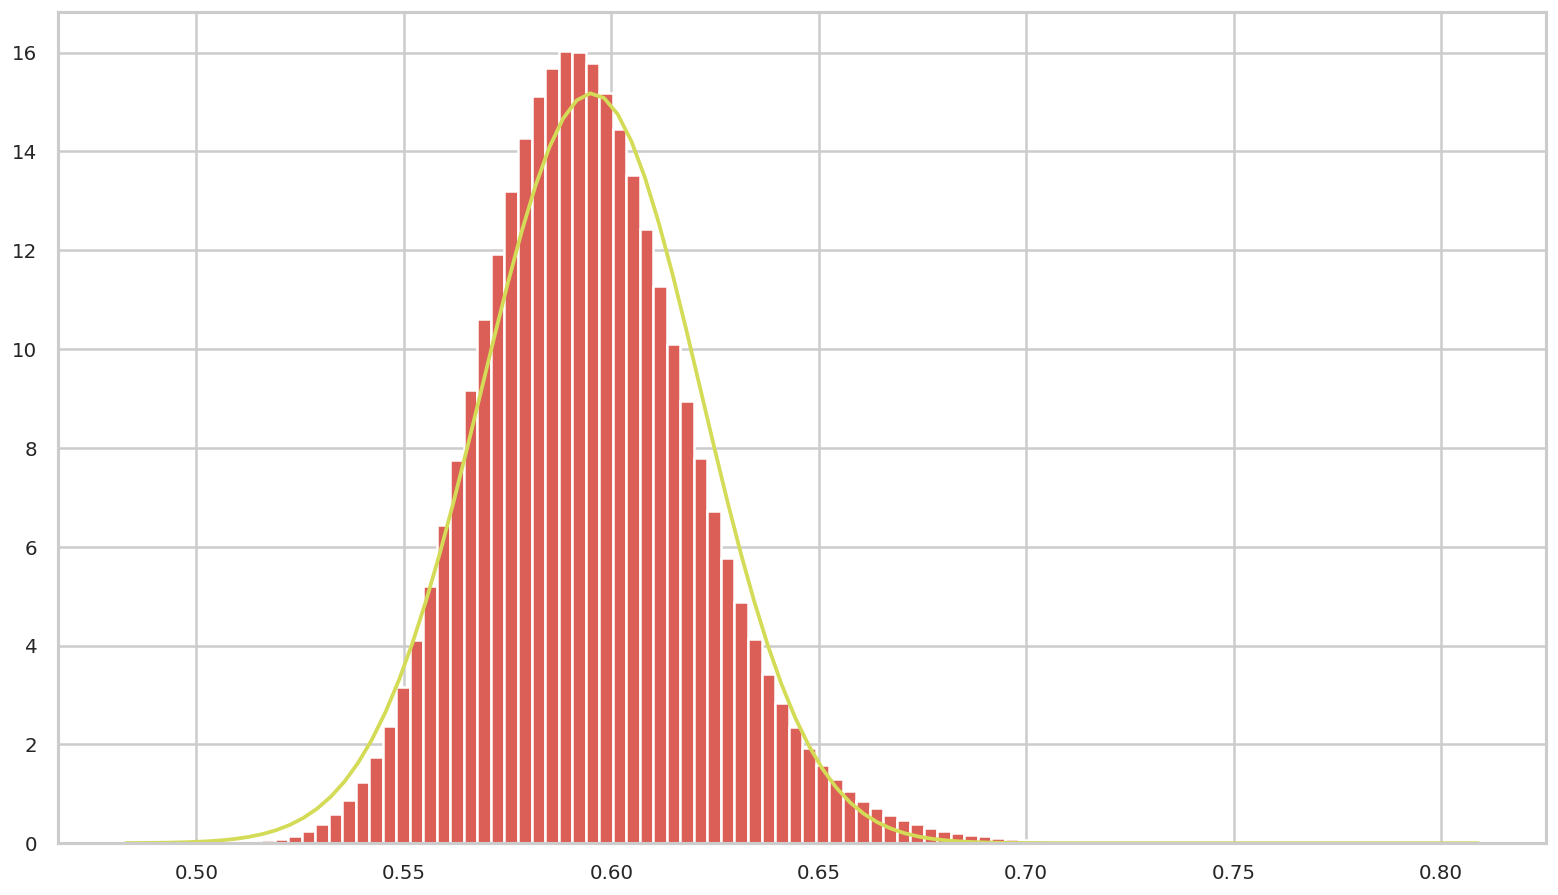

In [224]:
maxes = scipy.stats.beta.rvs(policy.rewards, policy.pulls-policy.rewards, size=(10000000,len(policy.rewards))).max(axis=1)
max_beta = scipy.stats.beta.fit(maxes, floc=0, fscale=1)
print(max_beta)
plt.hist(maxes, density=True, bins = 100)
x = np.linspace(min(maxes), max(maxes), 100)
plt.plot(x, scipy.stats.beta.pdf(x, max_beta[0], max_beta[1]))

In [223]:
max_beta = scipy.stats.beta.fit(maxes, floc=0, fscale=1)

In [174]:
import scipy
max_beta = scipy.stats.beta.fit(maxes, floc=0, fscale=1)

In [177]:
max_beta

(592.1471104254124, 68.66022894928807, 0, 1)

Implement tabular Q-learning (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [ ]:
from SMPyBandits.Policies.klUCBPlus import klUCBPlus
from SMPyBandits.Policies.CPUCB import CPUCB
from SMPyBandits.Policies.klUCB import klUCB
#initialize episodic structure
init()
num_episodes=20000; #number of training episodes, you can increase this to train more
episode_max_length=100;
#initialize discount factor, learning rate
gamma=0.95
learnRate=0.8

#create Q table
policies = {}

#execute in episodes
for i in range(num_episodes):

    #reset the environment at the beginning of an episode
    s = env.reset()
    d = False #not done
    state_action_pairs = []
    max_r = 0
    for t in range(episode_max_length):

        ###########SELCT ACTION a for state s using Q-values ##################
        #example
        # a = np.argmax(scipy.stats.beta.ppf(.99,Q*n + 1/2, (1-Q)*n + 1/2)[s,:])
        
        a = policies.setdefault(s, klUCBPlus(4)).choice()
        #a = env.action_space.sample()  #currently selecting a random action, change this

        #get new state, reward, done
        s1, r, d, _ = env.step(a)
        max_r = max(r, max_r)
        ##### update Q(s,a) ############
        state_action_pairs.append((s,a))
        #break if done, reached terminal state
        if d == True:
            break
        s=s1
    for s, a in state_action_pairs:
        policies[s].getReward(a, max_r)

    #log per-episode reward and moving average over 100 episodes
    wandb.log({ "training reward" : rEpisode, "training reward moving average" : movingAverage, "training episode" : i})
wandb.run.summary["number of training episodes"]=num_episodes

In [ ]:
%%wandb
## DO NOT CHANGE THIS CELL. CHANGING ANY PART OF THIS CELL CAN DISQUALIFY THE SUBMISSION
#Evaluation of trained policy
init()
num_episodes=1000; #number of episodes for evaluation
episode_max_length=100;
movingAverageArray=[]
score=0
env.reset()
for i in range(num_episodes):
    s = env.reset()
    d = False #not done
    for t in range(episode_max_length):
        a = np.argmax(Q[s,:])
        s, r, d, _ = env.step(a)
        if d == True:
            break
    #log per-episode reward and moving average over 100 episodes
    wandb.log({ "evaluation reward" : rEpisode, "evaluation reward moving average" : movingAverage, "evaluation episode" : i})
    movingAverageArray.append(movingAverage)
    #score is x if there is a window of 100 consecutive episodes where moving average was at least x
    if i>100:
        score=max(score,min(movingAverageArray[i-100:i-1]))


wandb.run.summary["score"]=score

In [ ]:
print(Q)

[[0.63054707 0.05144695 0.03673469 0.00920245]
 [0.01257862 0.02702703 0.02272727 0.4373395 ]
 [0.38890392 0.01162791 0.11983471 0.        ]
 [0.03225806 0.         0.         0.14492754]
 [0.6288024  0.04081633 0.05357143 0.        ]
 [0.         0.         0.         0.        ]
 [0.3480068  0.17333333 0.33327728 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.1369863  0.04477612 0.64080161]
 [0.30487805 0.67377624 0.23728814 0.09375   ]
 [0.63016748 0.45323741 0.29885057 0.15555556]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.04347826 0.76498742 0.22222222]
 [0.         0.87808498 0.66956522 0.62745098]
 [0.         0.         0.         0.        ]]


In [ ]:
print(n)

[[2.52273e+05 6.22000e+02 4.90000e+02 3.26000e+02]
 [1.59000e+02 1.85000e+02 1.76000e+02 3.89400e+03]
 [7.39000e+03 8.60000e+01 2.42000e+02 8.10000e+01]
 [6.20000e+01 4.70000e+01 4.80000e+01 1.38000e+02]
 [1.90998e+05 1.96000e+02 2.24000e+02 1.33000e+02]
 [1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]
 [5.29300e+03 2.25000e+02 5.94700e+03 6.40000e+01]
 [1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]
 [5.10000e+01 1.46000e+02 6.70000e+01 1.30588e+05]
 [8.20000e+01 7.18280e+04 5.90000e+01 3.20000e+01]
 [2.74070e+04 2.78000e+02 8.70000e+01 4.50000e+01]
 [1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]
 [1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]
 [2.00000e+01 2.30000e+01 5.72480e+04 3.60000e+01]
 [1.50000e+01 4.17750e+04 2.30000e+02 1.53000e+02]
 [1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]]


In [ ]:
run.finish()

evaluation episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
evaluation reward,▁████▁██████▁███████▁██████████▁█████▁██
evaluation reward moving average,█▆▅▂▂▃▄▅▄▅▆▆▆▃▃▂▂▄▄▃▄▄▂▅▄▄▄▁▅▄▆█▅▆▄▄▆▅▆▆
random episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
random reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
random reward moving average,▁▁▁▁▁▁▃▃▃▃▁▅▅▅▅▁▁▃▃▅▅▃▃▅▆▆▆▆▃▃▃▁▁▃▆▆▆█▆▅
training episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training reward,▁▁▁██▁▁█▁▁████▁█▁██▁▁▁▁██████████▁█████▁
training reward moving average,▁▁▆▆▇▇▇▆▇▆▇▆▇▇▇█▇▇▆▇▆▇▇▇▇▇▇▇▇▇██▇▇▇▆▇▇█▇
evaluation episode,999
evaluation reward,1.0
